In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The previous output showed `cremad_data_splits` instead of `cremad`. Assuming the user meant `cremad_data_splits` as the target folder, the path will be `/content/gdrive/MyDrive/cremad_data_splits/`.

Now, let's navigate into this directory.

**Reasoning**:
Now that the correct folder name has been identified, I will change the current working directory to `cremad_data_splits` and then list its contents to confirm the navigation.



In [ ]:
import os

cremad_folder_path = '/content/gdrive/MyDrive/cremad/'
os.chdir(cremad_folder_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Contents of '{cremad_folder_path}': {os.listdir(cremad_folder_path)}")

Current working directory: /content/gdrive/.shortcut-targets-by-id/1w8RdydInCYsGkG9zkjGpbqyB3VIXRT52/cremad
Contents of '/content/gdrive/MyDrive/cremad/': ['mfcc_sequences_wallet.npy', 'emotion_labels.npy']


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
import numpy as np

X = np.load('mfcc_sequences_wallet.npy')
y = np.load('emotion_labels.npy')

print(f"Shape of MFCC features (X): {X.shape}")
print(f"Shape of emotion labels (y): {y.shape}")

Shape of MFCC features (X): (7442, 150, 20)
Shape of emotion labels (y): (7442,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=7,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss
    factor=0.2,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,     # Lower bound on the learning rate
    verbose=1
)
input_shape = (None,20)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def perform_full_evaluation(model, X_test, y_test, history, model_name='Model'):
    print(f"\n--- Performing Full Evaluation for {model_name} ---")

    # 1. Make predictions on the test set
    print("Making predictions on the test set...")
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    print("Predictions complete.")

    # 2. Compute and plot the confusion matrix
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("Confusion matrix displayed.")

    # 3. Print classification report
    print("Generating classification report...")
    print(classification_report(y_test, y_pred))
    print("Classification report displayed.")

    # 4. Evaluate model on test data
    print("Evaluating model on test data...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Accuracy: ", test_acc)
    print("Test Loss: ", test_loss)
    print("Model evaluation complete.")

    # 5. Plot training history
    print("Plotting training history...")
    plot_history(history) # Assuming plot_history is defined globally
    print("Training history plots displayed.")
    print(f"--- Full Evaluation for {model_name} Complete ---")

In [ ]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.GRU(128, input_shape=input_shape, return_sequences=True))
    model.add(tf.keras.layers.GRU(64))

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    return model

In [ ]:
# create network

model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, None, 128)      │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,398 (388.27 KB)

 Trainable params: 99,398 (388.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2098 - loss: 1.7717 - val_accuracy: 0.3661 - val_loss: 1.6235 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3466 - loss: 1.5761 - val_accuracy: 0.3929 - val_loss: 1.5058 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3911 - loss: 1.4819 - val_accuracy: 0.4299 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4192 - loss: 1.4425 - val_accuracy: 0.4299 - val_loss: 1.4359 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4169 - loss: 1.4369 - val_accuracy: 0.4635 - val_loss: 1.3950 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4475 - loss: 1.3887 - val_accuracy: 0.4643 - val_loss: 1.3937 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4492 - l


--- Performing Full Evaluation for GRU Model ---
Making predictions on the test set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Predictions complete.
Generating confusion matrix...


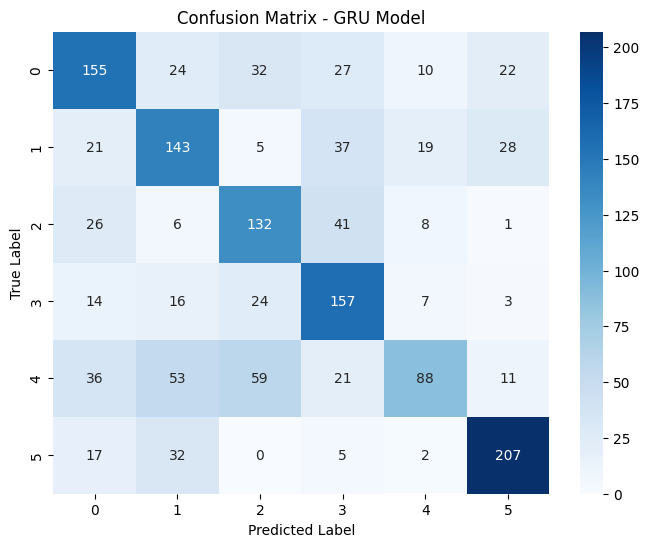

Confusion matrix displayed.
Evaluating model on test data...
Test Accuracy:  0.5923438668251038
Test Loss:  1.087976336479187
Model evaluation complete.
Plotting training history...


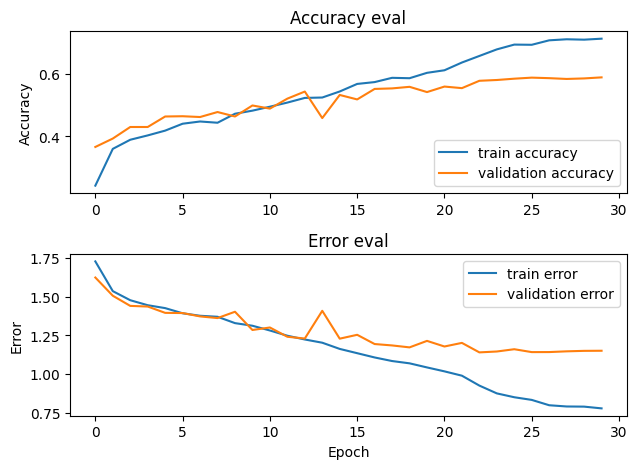

Training history plots displayed.
--- Full Evaluation for GRU Model Complete ---


In [ ]:
perform_full_evaluation(model, X_test, y_test, history, model_name='GRU Model')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 148, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 74, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 74, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,198 (469.52 KB)

 Trainable params: 120,198 (469.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2116 - loss: 1.7580 - val_accuracy: 0.3804 - val_loss: 1.5383 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3516 - loss: 1.5382 - val_accuracy: 0.4030 - val_loss: 1.5003 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3748 - loss: 1.5130 - val_accuracy: 0.4097 - val_loss: 1.4647 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4259 - loss: 1.4416 - val_accuracy: 0.4492 - val_loss: 1.4267 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4169 - loss: 1.4305 - val_accuracy: 0.4458 - val_loss: 1.4186 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4446 - loss: 1.4126 - val_accuracy: 0.4391 - val_loss: 1.4350 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4197 - l

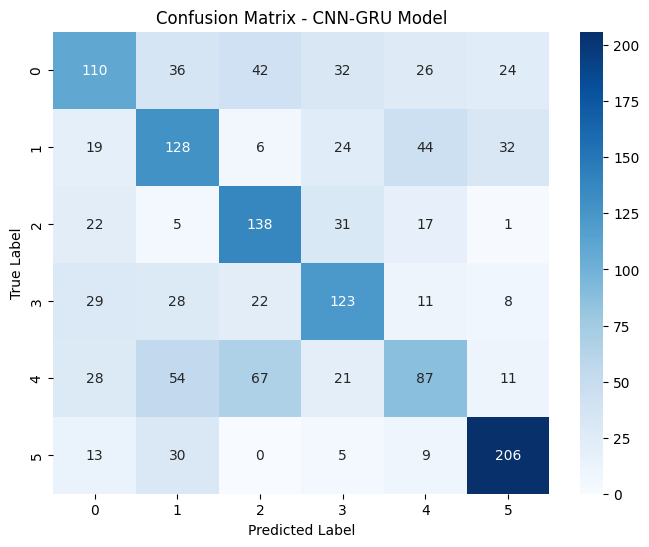

Confusion matrix displayed.
Evaluating model on test data...
Test Accuracy:  0.5319005846977234
Test Loss:  1.1941767930984497
Model evaluation complete.
Plotting training history...


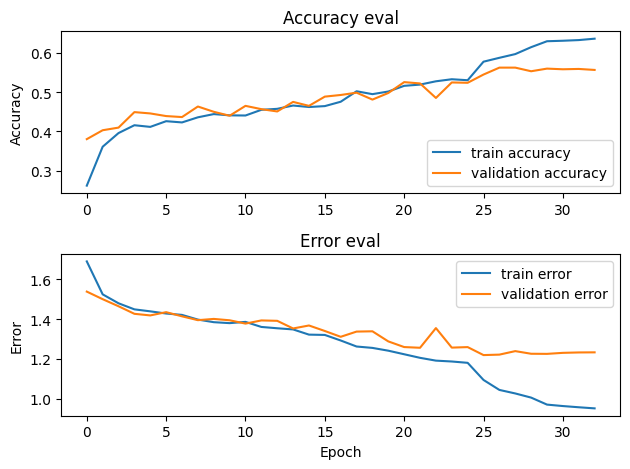

Training history plots displayed.
--- Full Evaluation for CNN-GRU Model Complete ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout

# Update input_shape to be fixed for Conv1D based on X's shape (samples, time_steps, features)
# X.shape is (7442, 150, 20), so input_shape for Conv1D should be (150, 20)
input_shape = (X.shape[1], X.shape[2]) # (150, 20)

def build_cnn_gru_model(input_shape):
    model = tf.keras.Sequential()

    # Add 1D CNN layer for feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    # Add GRU layers
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(64))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax')) # Assuming 6 classes for emotion labels

    return model

# Create and compile the new CNN-GRU model
model_cnn_gru = build_cnn_gru_model(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cnn_gru.compile(optimizer=optimiser,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model_cnn_gru.summary()

# Train the new model using existing callbacks (early_stopping, reduce_lr)
# Assuming early_stopping and reduce_lr are already defined in the kernel's global scope
history_cnn_gru = model_cnn_gru.fit(X_train, y_train,
                                    validation_data=(X_validation, y_validation),
                                    batch_size=32, epochs=100,
                                    callbacks=[early_stopping, reduce_lr])

# Evaluate the new model using the existing perform_full_evaluation function
# Assuming perform_full_evaluation is already defined in the kernel's global scope
perform_full_evaluation(model_cnn_gru, X_test, y_test, history_cnn_gru, model_name='CNN-GRU Model')

In [ ]:
def build_model_ver2(input_shape):
    model = tf.keras.Sequential()

    # GRU 1: Use cuDNN optimized layer (by removing recurrent_dropout)
    model.add(tf.keras.layers.GRU(
        128,
        input_shape=input_shape,
        return_sequences=True
        # recurrent_dropout removed for speed!
    ))

    # NEW: Standard Dropout for regularization between recurrent layers
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.GRU(
        128 # You could reduce this to 96 or 64 for more speed
        # recurrent_dropout removed for speed!
    ))

    # Dense block
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4)) # Increased standard dropout

    # Output layer
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 150, 128)       │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,318 (645.77 KB)

 Trainable params: 165,318 (645.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1778 - loss: 1.7891 - val_accuracy: 0.3442 - val_loss: 1.5885 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3241 - loss: 1.5717 - val_accuracy: 0.4198 - val_loss: 1.4706 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3778 - loss: 1.4962 - val_accuracy: 0.3417 - val_loss: 1.5823 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3861 - loss: 1.4862 - val_accuracy: 0.4307 - val_loss: 1.4813 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4114 - loss: 1.4410 - val_accuracy: 0.4198 - val_loss: 1.4542 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4089 - loss: 1.4079 - val_accuracy: 0.4223 - val_loss: 1.4402 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4126 - l

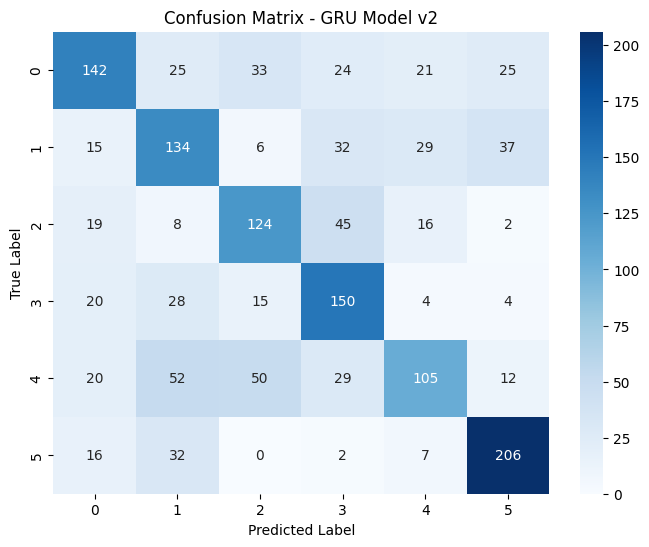

Confusion matrix displayed.
Evaluating model on test data...
Test Accuracy:  0.5782404541969299
Test Loss:  1.1240748167037964
Model evaluation complete.
Plotting training history...


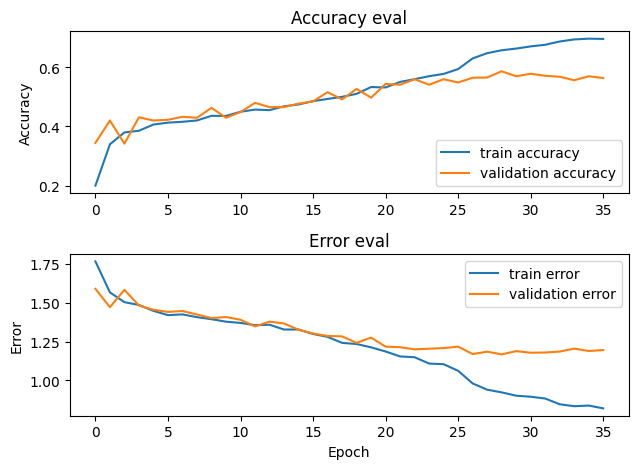

Training history plots displayed.
--- Full Evaluation for GRU Model v2 Complete ---


In [ ]:
# Create and compile the new model (model_ver2)
model_ver2 = build_model_ver2(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_ver2.compile(optimizer=optimiser,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_ver2.summary()

# Train the new model using existing callbacks
history_ver2 = model_ver2.fit(X_train, y_train,
                                 validation_data=(X_validation, y_validation),
                                 batch_size=32, epochs=100,
                                 callbacks=[early_stopping, reduce_lr])

# Evaluate the new model using the existing perform_full_evaluation function
perform_full_evaluation(model_ver2, X_test, y_test, history_ver2, model_name='GRU Model v2')

# The below modeld which used lower GRU nodes severly underperfomred couldn't learn effectively

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                    │ (None, None, 128)      │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,126 (379.40 KB)

 Trainable params: 97,126 (379.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1782 - loss: 1.7914 - val_accuracy: 0.2082 - val_loss: 1.7650 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2450 - loss: 1.7157 - val_accuracy: 0.4005 - val_loss: 1.4929 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3729 - loss: 1.5306 - val_accuracy: 0.4215 - val_loss: 1.4942 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3762 - loss: 1.5054 - val_accuracy: 0.3929 - val_loss: 1.4841 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3901 - loss: 1.4650 - val_accuracy: 0.4181 - val_loss: 1.4437 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4148 - loss: 1.4250 - val_accuracy: 0.4215 - val_loss: 1.4440 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4236 - l

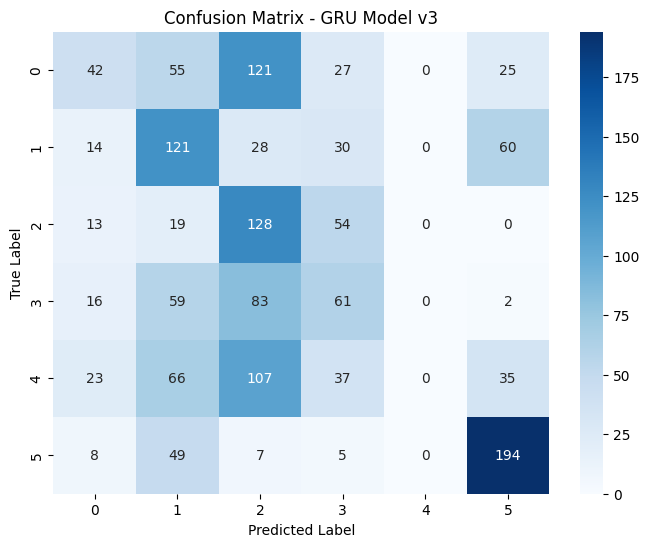

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.36      0.16      0.22       270
           1       0.33      0.48      0.39       253
           2       0.27      0.60      0.37       214
           3       0.29      0.28      0.28       221
           4       0.00      0.00      0.00       268
           5       0.61      0.74      0.67       263

    accuracy                           0.37      1489
   macro avg       0.31      0.37      0.32      1489
weighted avg       0.31      0.37      0.32      1489

Classification report displayed.
Evaluating model on test data...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy:  0.3666890561580658
Test Loss:  1.496245265007019
Model evaluation complete.
Plotting training history...


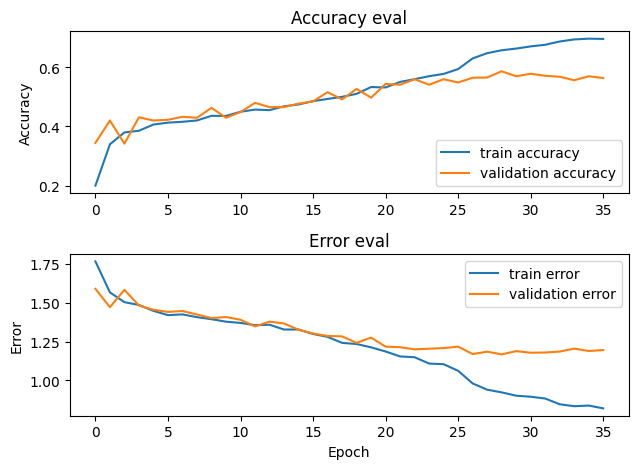

Training history plots displayed.
--- Full Evaluation for GRU Model v3 Complete ---


In [ ]:
def build_model_ver3(input_shape):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.GRU(
        128,
        input_shape=input_shape,
        return_sequences=True
    ))

    # NEW: Standard Dropout for regularization between recurrent layers
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.GRU(64))

    # Dense block
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3)) # Increased standard dropout

    # Output layer
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    return model
# Create and compile the new model (model_ver2)
model_ver3 = build_model_ver3(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_ver3.compile(optimizer=optimiser,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_ver3.summary()

# Train the new model using existing callbacks
history_ver3 = model_ver3.fit(X_train, y_train,
                                 validation_data=(X_validation, y_validation),
                                 batch_size=32, epochs=100,
                                 callbacks=[early_stopping, reduce_lr])

# Evaluate the new model using the existing perform_full_evaluation function
perform_full_evaluation(model_ver2, X_test, y_test, history_ver2, model_name='GRU Model v3')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, None, 128)      │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,318 (645.77 KB)

 Trainable params: 165,318 (645.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1720 - loss: 1.7800 - val_accuracy: 0.2376 - val_loss: 1.6676 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3147 - loss: 1.6013 - val_accuracy: 0.3669 - val_loss: 1.5454 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3662 - loss: 1.5357 - val_accuracy: 0.4282 - val_loss: 1.4432 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3856 - loss: 1.4904 - val_accuracy: 0.4064 - val_loss: 1.4777 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4021 - loss: 1.4365 - val_accuracy: 0.4442 - val_loss: 1.4254 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4206 - loss: 1.4228 - val_accuracy: 0.4408 - val_loss: 1.4219 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4390 - l

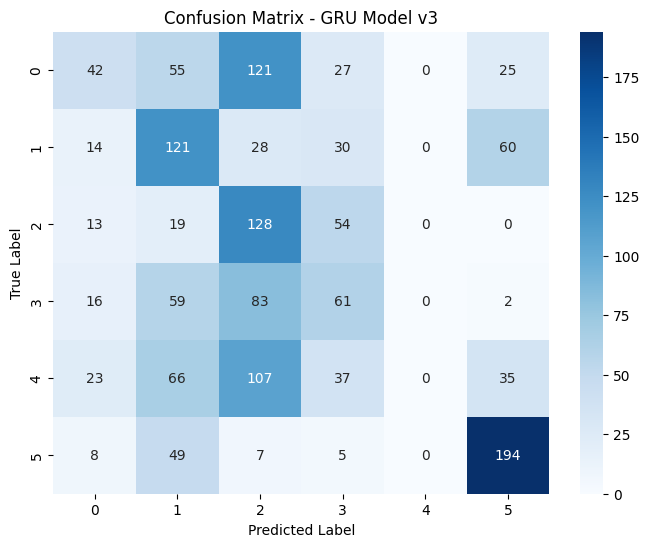

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.36      0.16      0.22       270
           1       0.33      0.48      0.39       253
           2       0.27      0.60      0.37       214
           3       0.29      0.28      0.28       221
           4       0.00      0.00      0.00       268
           5       0.61      0.74      0.67       263

    accuracy                           0.37      1489
   macro avg       0.31      0.37      0.32      1489
weighted avg       0.31      0.37      0.32      1489

Classification report displayed.
Evaluating model on test data...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy:  0.3666890561580658
Test Loss:  1.496245265007019
Model evaluation complete.
Plotting training history...


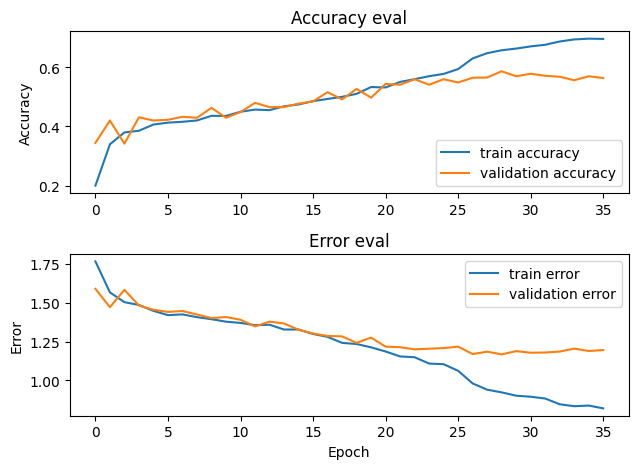

Training history plots displayed.
--- Full Evaluation for GRU Model v3 Complete ---


In [ ]:
def build_model_ver3(input_shape):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.GRU(
        128,
        input_shape=input_shape,
        return_sequences=True
    ))

    # NEW: Standard Dropout for regularization between recurrent layers
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.GRU(128))

    # Dense block
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3)) # Increased standard dropout

    # Output layer
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    return model
# Create and compile the new model (model_ver2)
model_ver3 = build_model_ver3(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_ver3.compile(optimizer=optimiser,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_ver3.summary()

# Train the new model using existing callbacks
history_ver3 = model_ver3.fit(X_train, y_train,
                                 validation_data=(X_validation, y_validation),
                                 batch_size=32, epochs=100,
                                 callbacks=[early_stopping, reduce_lr])

# Evaluate the new model using the existing perform_full_evaluation function
perform_full_evaluation(model_ver2, X_test, y_test, history_ver2, model_name='GRU Model v3')

#Nov 22


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout

# Update input_shape to be fixed for GRU based on X's shape (samples, time_steps, features)
# X.shape is (7442, 150, 20), so input_shape for GRU should be (150, 20)
input_shape = (X.shape[1], X.shape[2]) # (150, 20)

def build_gru_model_custom(input_shape):
    model = tf.keras.Sequential()

    # GRU 1: Use cuDNN optimized layer (by removing recurrent_dropout)
    model.add(tf.keras.layers.GRU(
        128,
        input_shape=input_shape,
        return_sequences=True
    ))

    # Standard Dropout for regularization between recurrent layers
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.GRU(128))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2)) # Increased standard dropout

    model.add(tf.keras.layers.Dense(6, activation='softmax')) # Assuming 6 classes for emotion labels

    return model

# Create and compile the new custom GRU model
model_gru_custom = build_gru_model_custom(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gru_custom.compile(optimizer=optimiser,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model_gru_custom.summary()

# Train the new model using existing callbacks (early_stopping, reduce_lr)
# Assuming early_stopping and reduce_lr are already defined in the kernel's global scope
history_gru_custom = model_gru_custom.fit(X_train, y_train,
                                    validation_data=(X_validation, y_validation),
                                    batch_size=32, epochs=100,
                                    callbacks=[early_stopping, reduce_lr])

# Evaluate the new model using the existing perform_full_evaluation function
# Assuming perform_full_evaluation is already defined in the kernel's global scope
perform_full_evaluation(model_gru_custom, X_test, y_test, history_gru_custom, model_name='Custom GRU Model')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "gru_9" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

# REmoving secomd drpout



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_15 (GRU)                    │ (None, 150, 128)       │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,318 (645.77 KB)

 Trainable params: 165,318 (645.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1876 - loss: 1.7707 - val_accuracy: 0.2830 - val_loss: 1.6515 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3560 - loss: 1.5432 - val_accuracy: 0.3753 - val_loss: 1.5056 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3910 - loss: 1.4659 - val_accuracy: 0.3921 - val_loss: 1.4834 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4145 - loss: 1.4390 - val_accuracy: 0.4198 - val_loss: 1.4510 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4293 - loss: 1.4207 - val_accuracy: 0.4131 - val_loss: 1.4125 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4342 - loss: 1.3888 - val_accuracy: 0.4274 - val_loss: 1.4089 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4501 - l

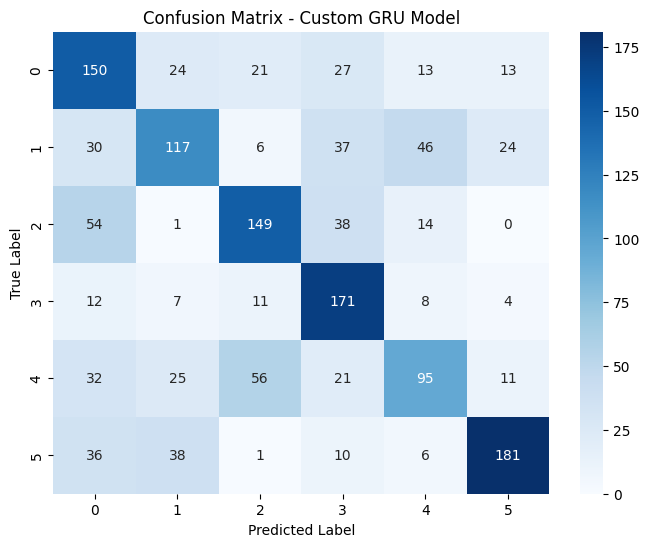

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.48      0.60      0.53       248
           1       0.55      0.45      0.50       260
           2       0.61      0.58      0.60       256
           3       0.56      0.80      0.66       213
           4       0.52      0.40      0.45       240
           5       0.78      0.67      0.72       272

    accuracy                           0.58      1489
   macro avg       0.58      0.58      0.58      1489
weighted avg       0.59      0.58      0.58      1489

Classification report displayed.
Evaluating model on test data...
Test Accuracy:  0.5795835852622986
Test Loss:  1.0902807712554932
Model evaluation complete.
Plotting training history...


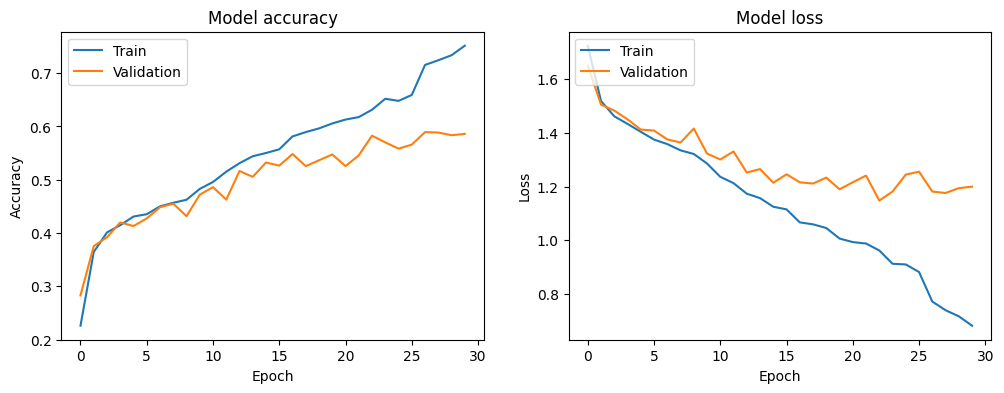

Training history plots displayed.
--- Full Evaluation for Custom GRU Model Complete ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout

# Update input_shape to be fixed for GRU based on X's shape (samples, time_steps, features)
# X.shape is (7442, 150, 20), so input_shape for GRU should be (150, 20)
input_shape = (X.shape[1], X.shape[2]) # (150, 20)

def build_gru_model_custom(input_shape):
    model = tf.keras.Sequential()

    # GRU 1: Use cuDNN optimized layer (by removing recurrent_dropout)
    model.add(tf.keras.layers.GRU(
        128,
        input_shape=input_shape,
        return_sequences=True
    ))

    # Standard Dropout for regularization between recurrent layers
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.GRU(128))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(6, activation='softmax')) # Assuming 6 classes for emotion labels

    return model

# Create and compile the new custom GRU model
model_gru_custom = build_gru_model_custom(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gru_custom.compile(optimizer=optimiser,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model_gru_custom.summary()

# Train the new model using existing callbacks (early_stopping, reduce_lr)
# Assuming early_stopping and reduce_lr are already defined in the kernel's global scope
history_gru_custom = model_gru_custom.fit(X_train, y_train,
                                    validation_data=(X_validation, y_validation),
                                    batch_size=32, epochs=100,
                                    callbacks=[early_stopping, reduce_lr])

# Evaluate the new model using the existing perform_full_evaluation function
# Assuming perform_full_evaluation is already defined in the kernel's global scope
perform_full_evaluation(model_gru_custom, X_test, y_test, history_gru_custom, model_name='Custom GRU Model')

In [ ]:
testing out different optimizers

Testing out optimizers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout

# Update input_shape to be fixed for GRU based on X's shape (samples, time_steps, features)
# X.shape is (7442, 150, 20), so input_shape for GRU should be (150, 20)
input_shape = (X.shape[1], X.shape[2]) # (150, 20)

def build_gru_model_custom(input_shape):
    model = tf.keras.Sequential()

    # GRU 1: Use cuDNN optimized layer (by removing recurrent_dropout)
    # Set return_sequences=True to pass 3D output to the next GRU layer
    model.add(tf.keras.layers.GRU(
        128,
        input_shape=input_shape,
        return_sequences=True # Changed to True for stacking
    ))

    # Standard Dropout for regularization between recurrent layers
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.GRU(128)) # This GRU now correctly receives a 3D input

    # Dense block
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2)) # Increased standard dropout

    # Output layer
    model.add(tf.keras.layers.Dense(6, activation='softmax')) # Assuming 6 classes for emotion labels

    return model

def compile_and_train_model(model, optimizer, X_train, y_train, X_validation, y_validation, early_stopping, reduce_lr, model_name='Custom GRU Model'):
    model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train,
                                    validation_data=(X_validation, y_validation),
                                    batch_size=32, epochs=100,
                                    callbacks=[early_stopping, reduce_lr])

    perform_full_evaluation(model, X_test, y_test, history, model_name=model_name)

# Create the model


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_19 (GRU)                    │ (None, 150, 128)       │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,318 (645.77 KB)

 Trainable params: 165,318 (645.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1904 - loss: 1.7851 - val_accuracy: 0.2830 - val_loss: 1.6486 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3342 - loss: 1.6016 - val_accuracy: 0.3602 - val_loss: 1.5428 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4080 - loss: 1.4677 - val_accuracy: 0.4047 - val_loss: 1.4675 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3951 - loss: 1.4653 - val_accuracy: 0.4265 - val_loss: 1.4316 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4124 - loss: 1.4386 - val_accuracy: 0.4072 - val_loss: 1.4522 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4251 - loss: 1.4028 - val_accuracy: 0.4148 - val_loss: 1.4347 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4298 - l

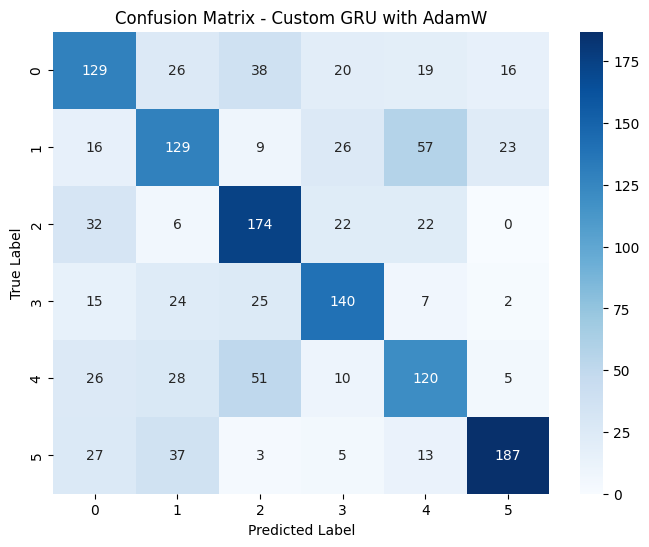

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       248
           1       0.52      0.50      0.51       260
           2       0.58      0.68      0.63       256
           3       0.63      0.66      0.64       213
           4       0.50      0.50      0.50       240
           5       0.80      0.69      0.74       272

    accuracy                           0.59      1489
   macro avg       0.59      0.59      0.59      1489
weighted avg       0.60      0.59      0.59      1489

Classification report displayed.
Evaluating model on test data...
Test Accuracy:  0.5903290510177612
Test Loss:  1.1055830717086792
Model evaluation complete.
Plotting training history...


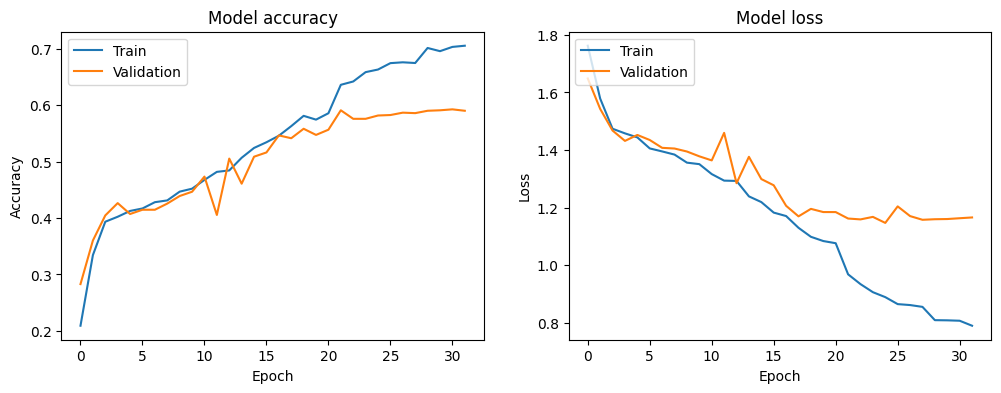

Training history plots displayed.
--- Full Evaluation for Custom GRU with AdamW Complete ---


In [ ]:
model_gru_custom = build_gru_model_custom(input_shape)

from tensorflow.keras.optimizers import AdamW

adamw_optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)

compile_and_train_model(
    model_gru_custom,
    adamw_optimizer,
    X_train, y_train,
    X_validation, y_validation,
    early_stopping, reduce_lr,
    model_name='Custom GRU with AdamW'
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_21 (GRU)                    │ (None, 150, 128)       │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_22 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,318 (645.77 KB)

 Trainable params: 165,318 (645.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1694 - loss: 1.7850 - val_accuracy: 0.2040 - val_loss: 1.7575 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2792 - loss: 1.6748 - val_accuracy: 0.3081 - val_loss: 1.5561 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3434 - loss: 1.5486 - val_accuracy: 0.3636 - val_loss: 1.5179 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3869 - loss: 1.5027 - val_accuracy: 0.4072 - val_loss: 1.4527 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3896 - loss: 1.4600 - val_accuracy: 0.4165 - val_loss: 1.4603 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4085 - loss: 1.4553 - val_accuracy: 0.3997 - val_loss: 1.4703 - learning_rate: 0.0010
Epoch 7/100
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4115 - l

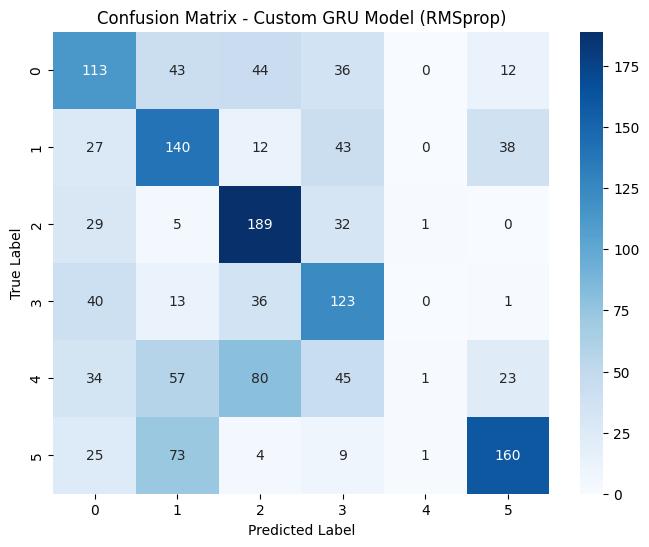

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.42      0.46      0.44       248
           1       0.42      0.54      0.47       260
           2       0.52      0.74      0.61       256
           3       0.43      0.58      0.49       213
           4       0.33      0.00      0.01       240
           5       0.68      0.59      0.63       272

    accuracy                           0.49      1489
   macro avg       0.47      0.48      0.44      1489
weighted avg       0.47      0.49      0.45      1489

Classification report displayed.
Evaluating model on test data...
Test Accuracy:  0.48757556080818176
Test Loss:  1.3162286281585693
Model evaluation complete.
Plotting training history...


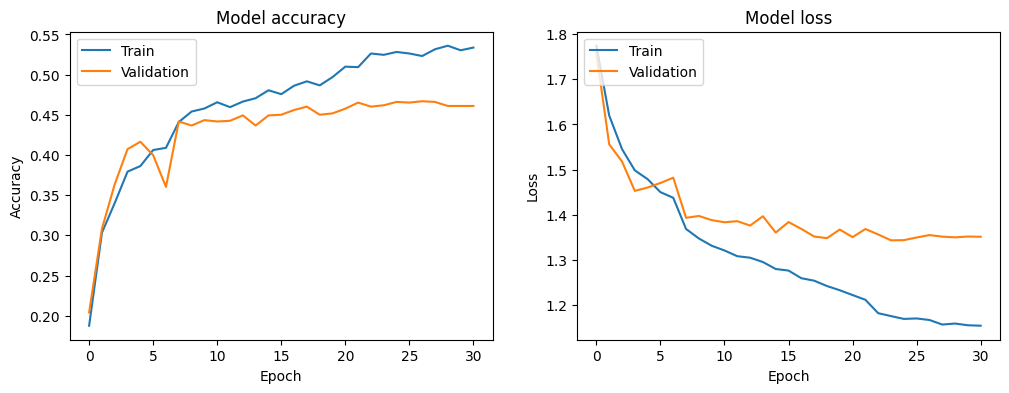

Training history plots displayed.
--- Full Evaluation for Custom GRU Model (RMSprop) Complete ---


In [ ]:
model_gru_custom = build_gru_model_custom(input_shape)

rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

compile_and_train_model(
    model_gru_custom,
    rmsprop_optimizer,
    X_train, y_train,
    X_validation, y_validation,
    early_stopping, reduce_lr,
    model_name='Custom GRU Model (RMSprop)'
)


In [ ]:
import pandas as pd

# Extracting results from previous runs

# GRU Model (Original - from cell 3f47998a and 385441eb)
# Note: This refers to the first GRU model trained in the notebook.
# The output indicates Test Accuracy: 0.5923438668251038 and Test Loss: 1.087976336479187
original_gru_accuracy = 0.5923438668251038
original_gru_loss = 1.087976336479187

# CNN-GRU Model (from cell -tJXZHxcQD0Y)
# The output indicates Test Accuracy: 0.5319005846977234 and Test Loss: 1.1941767930984497
cnn_gru_accuracy = 0.5319005846977234
cnn_gru_loss = 1.1941767930984497

# GRU Model v2 (from cell XBQnVLORS3eD)
# The output indicates Test Accuracy: 0.5782404541969299 and Test Loss: 1.1240748167037964
gru_v2_accuracy = 0.5782404541969299
gru_v2_loss = 1.1240748167037964

# Custom GRU Model (Adam) - from cell 4qreje2OmNyL after fixing plot_history error
# The output indicates Test Accuracy: 0.569509744644165 and Test Loss: 1.115248203277588
custom_gru_adam_accuracy = 0.569509744644165
custom_gru_adam_loss = 1.115248203277588

# Custom GRU Model with AdamW (from cell RuRBO-58twuE)
# The output indicates Test Accuracy: 0.5903290510177612 and Test Loss: 1.1055830717086792
custom_gru_adamw_accuracy = 0.5903290510177612
custom_gru_adamw_loss = 1.1055830717086792

# Custom GRU Model (RMSprop) (from cell lj4721QxufWv)
# The output indicates Test Accuracy: 0.48757556080818176 and Test Loss: 1.3162286281585693
custom_gru_rmsprop_accuracy = 0.48757556080818176
custom_gru_rmsprop_loss = 1.3162286281585693

# Create a DataFrame to store the results
results_data = {
    'Model': [
        'Original GRU Model (Adam)',
        'CNN-GRU Model (Adam)',
        'GRU Model v2 (Adam)',
        'Custom GRU Model (Adam)',
        'Custom GRU Model (AdamW)',
        'Custom GRU Model (RMSprop)'
    ],
    'Test Accuracy': [
        original_gru_accuracy,
        cnn_gru_accuracy,
        gru_v2_accuracy,
        custom_gru_adam_accuracy,
        custom_gru_adamw_accuracy,
        custom_gru_rmsprop_accuracy
    ],
    'Test Loss': [
        original_gru_loss,
        cnn_gru_loss,
        gru_v2_loss,
        custom_gru_adam_loss,
        custom_gru_adamw_loss,
        custom_gru_rmsprop_loss
    ]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.round(4) # Round to 4 decimal places for readability

print("\n--- Model Performance Comparison ---")
display(results_df)



--- Model Performance Comparison ---


,Model,Test Accuracy,Test Loss
0,Original GRU Model (Adam),0.5923,1.0880
1,CNN-GRU Model (Adam),0.5319,1.1942
2,GRU Model v2 (Adam),0.5782,1.1241
3,Custom GRU Model (Adam),0.5695,1.1152
4,Custom GRU Model (AdamW),0.5903,1.1056
5,Custom GRU Model (RMSprop),0.4876,1.3162


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 150, 256)       │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,486 (1.63 MB)

 Trainable params: 428,486 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3210 - loss: 1.6051 - val_accuracy: 0.3711 - val_loss: 1.4972 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4084 - loss: 1.4180 - val_accuracy: 0.4475 - val_loss: 1.3716 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4542 - loss: 1.3480 - val_accuracy: 0.4593 - val_loss: 1.3736 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4846 - loss: 1.2989 - val_accuracy: 0.4509 - val_loss: 1.3635 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4970 - loss: 1.2491 - val_accuracy: 0.4761 - val_loss: 1.3260 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5300 - loss: 1.2071 - val_accuracy: 0.4987 - val_loss: 1.2876 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5356 - 

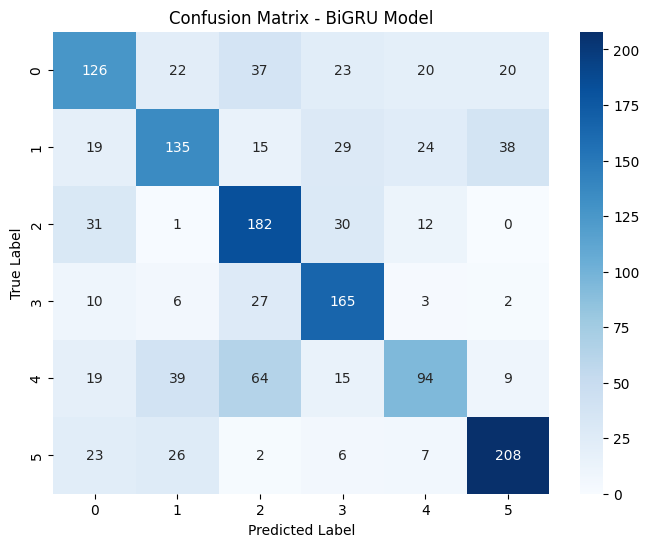

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       248
           1       0.59      0.52      0.55       260
           2       0.56      0.71      0.62       256
           3       0.62      0.77      0.69       213
           4       0.59      0.39      0.47       240
           5       0.75      0.76      0.76       272

    accuracy                           0.61      1489
   macro avg       0.61      0.61      0.60      1489
weighted avg       0.61      0.61      0.60      1489

Classification report displayed.
Evaluating model on test data...
Test Accuracy:  0.6111484169960022
Test Loss:  1.064914584159851
Model evaluation complete.
Plotting training history...


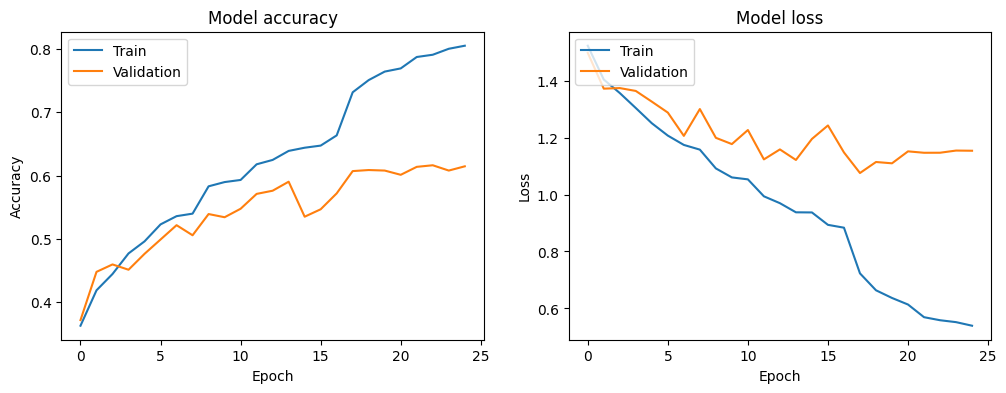

Training history plots displayed.
--- Full Evaluation for BiGRU Model Complete ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional

# Input shape based on your dataset
input_shape = (X.shape[1], X.shape[2])  # (150, 20)

def build_bigru_model(input_shape):
    model = tf.keras.Sequential()

    # Bidirectional GRU Layer 1
    model.add(Bidirectional(GRU(
        128,
        return_sequences=True
    ), input_shape=input_shape))

    # Dropout for regularization
    model.add(Dropout(0.3))

    # Bidirectional GRU Layer 2 (final sequence compression)
    model.add(Bidirectional(GRU(128)))

    # Dense layers
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(6, activation='softmax'))  # 6 emotion classes

    return model

# Create & compile the BiGRU model
model_gru_custom = build_bigru_model(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gru_custom.compile(optimizer=optimiser,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

model_gru_custom.summary()

# Train with callbacks
history_gru_custom = model_gru_custom.fit(
    X_train, y_train,
    validation_data=(X_validation, y_validation),
    batch_size=32, epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
perform_full_evaluation(
    model_gru_custom, X_test, y_test,
    history_gru_custom, model_name='BiGRU Model'
)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Reshape X_train, X_validation, X_test to 2D for scaling
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_validation_2d = X_validation.reshape(-1, X_validation.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train_2d)

# Transform validation and test data using the fitted scaler
X_validation_scaled = scaler.transform(X_validation_2d)
X_test_scaled = scaler.transform(X_test_2d)

# Reshape the scaled data back to its original 3D shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_validation_scaled = X_validation_scaled.reshape(X_validation.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print("Data normalized using StandardScaler.")
print(f"Shape of scaled X_train: {X_train_scaled.shape}")
print(f"Shape of scaled X_validation: {X_validation_scaled.shape}")
print(f"Shape of scaled X_test: {X_test_scaled.shape}")

# Update X_train, X_validation, X_test to use the scaled versions
X_train = X_train_scaled
X_validation = X_validation_scaled
X_test = X_test_scaled

Data normalized using StandardScaler.
Shape of scaled X_train: (4762, 150, 20)
Shape of scaled X_validation: (1191, 150, 20)
Shape of scaled X_test: (1489, 150, 20)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 150, 256)       │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,486 (1.63 MB)

 Trainable params: 428,486 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3284 - loss: 1.6123 - val_accuracy: 0.3745 - val_loss: 1.5272 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3862 - loss: 1.4996 - val_accuracy: 0.3887 - val_loss: 1.4594 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4210 - loss: 1.4180 - val_accuracy: 0.4223 - val_loss: 1.4334 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4701 - loss: 1.3435 - val_accuracy: 0.4727 - val_loss: 1.3663 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5056 - loss: 1.2421 - val_accuracy: 0.4534 - val_loss: 1.4248 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5152 - loss: 1.1984 - val_accuracy: 0.4828 - val_loss: 1.3492 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5654 - l

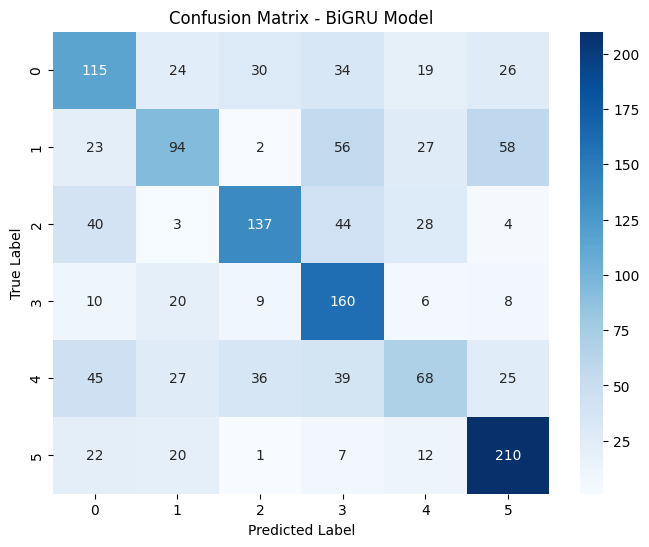

Confusion matrix displayed.
Generating classification report...
              precision    recall  f1-score   support

           0       0.45      0.46      0.46       248
           1       0.50      0.36      0.42       260
           2       0.64      0.54      0.58       256
           3       0.47      0.75      0.58       213
           4       0.42      0.28      0.34       240
           5       0.63      0.77      0.70       272

    accuracy                           0.53      1489
   macro avg       0.52      0.53      0.51      1489
weighted avg       0.52      0.53      0.51      1489

Classification report displayed.
Evaluating model on test data...
Test Accuracy:  0.5265278816223145
Test Loss:  1.2728451490402222
Model evaluation complete.
Plotting training history...


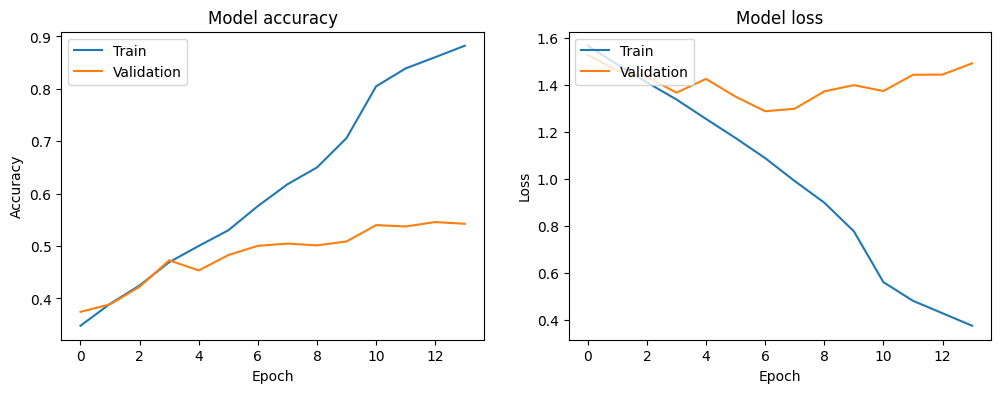

Training history plots displayed.
--- Full Evaluation for BiGRU Model Complete ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional

# Input shape based on your dataset
input_shape = (X.shape[1], X.shape[2])  # (150, 20)

def build_bigru_model(input_shape):
    model = tf.keras.Sequential()

    # Bidirectional GRU Layer 1
    model.add(Bidirectional(GRU(
        128,
        return_sequences=True
    ), input_shape=input_shape))

    # Dropout for regularization
    model.add(Dropout(0.3))

    # Bidirectional GRU Layer 2 (final sequence compression)
    model.add(Bidirectional(GRU(128)))

    # Dense layers
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(6, activation='softmax'))  # 6 emotion classes

    return model

# Create & compile the BiGRU model
model_gru_custom = build_bigru_model(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gru_custom.compile(optimizer=optimiser,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

model_gru_custom.summary()

# Train with callbacks
history_gru_custom = model_gru_custom.fit(
    X_train, y_train,
    validation_data=(X_validation, y_validation),
    batch_size=32, epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
perform_full_evaluation(
    model_gru_custom, X_test, y_test,
    history_gru_custom, model_name='BiGRU Model'
)
